# Zermelo (turnpike)

In [1]:
using MINPACK
using Plots
include("flow.jl")

# Parameters
Vmax = 1.0
h(y) = 3.0+0.2y*(1.0-y)
t0 = 0.0
y0 = [ 0.0, 0.0 ]
yf = [ 200.0, 1.0 ]

2-element Vector{Float64}:
 200.0
   1.0

In [2]:
# Regular maximised Hamiltonians and associated flow
H(y, p, u) = -1.0 + Vmax*p'*u + p[1]*h(y[2])
ur(p) = p / sqrt(p[1]^2+p[2]^2)
Hr(y, p) = H(y, p, ur(p))
fr = Flow(Hr)

(::var"#f#6"{var"#f#2#7"{var"#rhs!#4"{typeof(Hr)}}}) (generic function with 2 methods)

In [3]:
# Shooting function
function shoot(y1, p1, tf)

    yy0, p0 = fr(tf/2.0, y1, p1, t0)
    yyf, pf = fr(tf/2.0, y1, p1, tf)
    s = zeros(eltype(y1), 5)
    s[1:2] =  yy0-y0
    s[3:4] = (yyf-yf) ./ yf
    s[5] = Hr(y1, p1)

    return s

end

shoot (generic function with 1 method)

In [4]:
# Solve
y1 = [ (yf-y0)[1]/2.0, 0.5 ]
p1 = [ 1.0/(1.0+h(y1[2])), 0.0 ]
tf = (yf-y0)[1]/(1+h(y1[2]))
ξ = [ y1; p1; tf ]

foo(ξ) = shoot(ξ[1:2], ξ[3:4], ξ[5])
jfoo(ξ) = ForwardDiff.jacobian(foo, ξ)
foo!(s, ξ) = ( s[:] = foo(ξ); nothing )
jfoo!(js, ξ) = ( js[:] = jfoo(ξ); nothing )

println("Initial value of shooting:\n", foo(ξ), "\n\n")

nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol)
#nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if true #nl_sol.converged
    y1 = nl_sol.x[1:2]
    p1 = nl_sol.x[3:4]
    tf = nl_sol.x[5]
else
    error("Not converged")
end

Initial value of shooting:
[2.8270390144084726e-14, 0.5, -1.4210854715202004e-16, -0.5, 0.0]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.000000e-01     0.000000e+00         0.338086
     2     3.324239e-02     5.044212e-04         0.687964
     3     5.320052e-02     2.017685e-03         0.007306
     4     6.256129e-04     7.714361e-04         0.007396
     5     4.343793e-06     1.008298e-07         0.007585
     6     2.283069e-08     4.944570e-12         0.007680
     7     2.233924e-10     1.384149e-16         0.007851
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [100.0, 0.5, 0.2469135802469136, 0.0, 49.382716049382715]
 * Zero: [99.99999999994839, 0.5, 0.24691358024691326, 2.5957188626754667e-8, 49.42199951002432]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at m

49.42199951002432

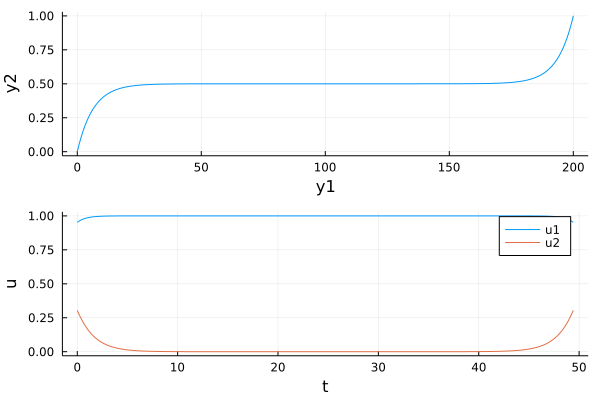

In [5]:
# Plots
ode_sol = fr((tf/2.0, t0), y1, p1)
N = length(ode_sol.t)
t = ode_sol.t[end:-1:1]
y = [ ode_sol[1:2, j] for j in N:-1:1 ]
p = [ ode_sol[3:4, j] for j in N:-1:1 ]

ode_sol = fr((tf/2.0, tf), y1, p1)
N = length(ode_sol.t)
t = [ t; ode_sol.t ]
y = [ y; [ ode_sol[1:2, j] for j in 1:N ] ]
p = [ p; [ ode_sol[3:4, j] for j in 1:N ] ]

u = ur.(p)
N = length(t)

y_plot  = plot([ y[i][1] for i=1:N ], [ y[i][2] for i=1:N ], xlabel = "y1", ylabel = "y2", legend = false)
u_plot = plot(t, [ u[i][1] for i=1:N ], xlabel = "t", ylabel = "u", label = "u1")
plot!(u_plot, t, [ u[i][2] for i=1:N ], label = "u2")
uy_plot = plot(y_plot, u_plot, layout = (2,1))
display(uy_plot); savefig(uy_plot, "fig4.pdf")